In [1]:
from model import load_model
from image_utils import imagenet_utils
import cv2 ,matplotlib.pyplot as plt
import numpy as np

In [2]:
orig_img,img=imagenet_utils.load_test_img("both.png")
# orig_img,img=imagenet_utils.load_test_img("dog.jpg")

In [3]:
test=load_model('VGG16')

In [4]:
model=test.model
input_dim=test.input_dim
layer_name='block5_conv3'

In [5]:
# Fredriks stuff, remove if not needed
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

In [6]:

from explanation_models import gradcam,gradcam_robust,gradcam_plusplus,guided_backprop

# GradCAM

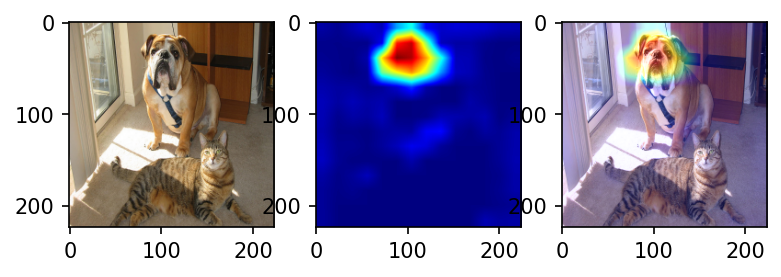

In [7]:
g= gradcam(model,layer_name,input_dim)
heatmap=g.get_heatmap(img)
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,heatmap)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

# GradCAM Robust - average

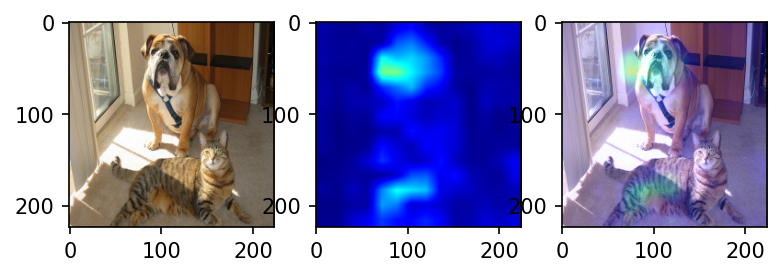

In [8]:
layers=['block5_conv1','block5_conv2','block5_conv3']
g_robust= gradcam_robust(model,layers,input_dim,'GradCAMpp')
heatmap=g_robust.get_heatmap(img)
final=(heatmap[0]+heatmap[1]+heatmap[2])/3.0
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,final)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

# GradCAM Robust - max

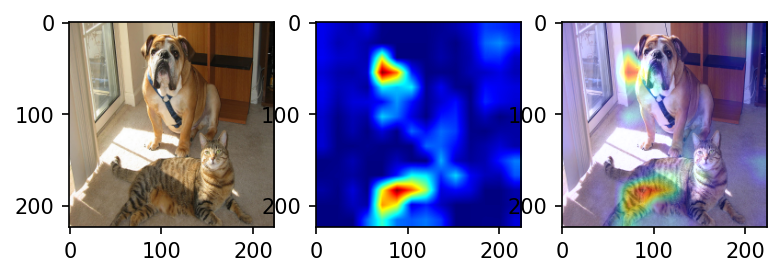

In [9]:
import tensorflow as tf
final=tf.math.maximum(heatmap[0],heatmap[1],heatmap[2])
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,final)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

# GradCAM++

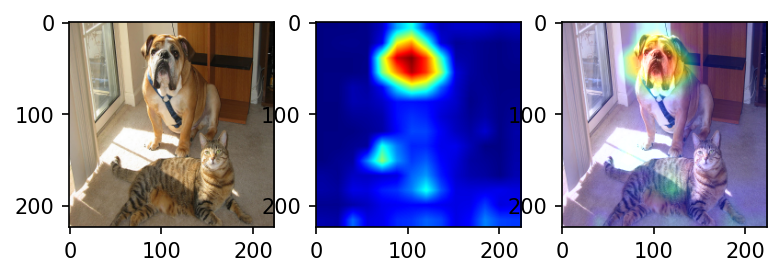

In [10]:
g= gradcam_plusplus(model,layer_name,input_dim)
heatmap=g.get_heatmap(img)
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,heatmap)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

# Guided Backprop + GradCAM

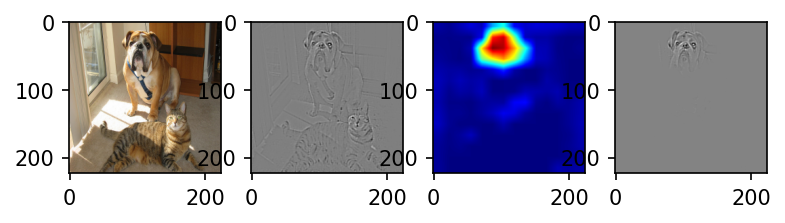

In [11]:
g1 = guided_backprop(model,layer_name,input_dim)
guided_bp=g1.get_heatmap(img)

g2 = gradcam(model,layer_name,input_dim)
heatmap=g2.get_heatmap(img)

heatmap_colormap, combined =imagenet_utils.combine_guided_bp(orig_img, heatmap, guided_bp)

f, axarr = plt.subplots(1,4)
axarr[0].imshow(orig_img)
axarr[1].imshow(guided_bp, cmap=plt.cm.gray)
axarr[2].imshow(heatmap_colormap)
axarr[3].imshow(combined, cmap=plt.cm.gray)